In [1]:
# This implementation consists of data preproccessing and RPN network as well as RPN loss functions
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import copy
import cv2
import matplotlib.pyplot as plt
import json
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from os import listdir
from os.path import isfile, join
import matplotlib.patches as patches
import ToolSet as TS

In [2]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# Print list of available GPUs
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Verify GPU support
print("GPU Support:", tf.test.is_built_with_cuda())
print("GPU Device Name:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Support: True
GPU Device Name: /device:GPU:0


In [3]:
ImageHeight = 500
ImageWidth = 666

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='StrawDI_Db1/train/',
    batch_size=1,
    shuffle=False,
    image_size=(ImageHeight, ImageWidth))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='StrawDI_Db1/val/',
    batch_size=1,
    shuffle=False,
    image_size=(ImageHeight, ImageWidth))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='StrawDI_Db1/test/',
    batch_size=1,
    shuffle=False,
    image_size=(ImageHeight, ImageWidth))


Found 2800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [4]:
toolSet = TS.Tools(ImageHeight,ImageWidth)

In [5]:
trainData = toolSet.ImageDataExtractor(train_ds)
valData = toolSet.ImageDataExtractor(val_ds)
testData = toolSet.ImageDataExtractor(test_ds)

In [6]:
toolSet.ImageDataSetter(trainData)

In [7]:
TrainingbboxLabels,TrainingCategoryLabels = toolSet.annotationgenerator("StrawDI_Db1/annotations/SDI_annotations/train/json/")
ValbboxLabels,ValCategoryLabels = toolSet.annotationgenerator("StrawDI_Db1/annotations/SDI_annotations/val/json/")
TestingbboxLabels,TestingCategoryLabels = toolSet.annotationgenerator("StrawDI_Db1/annotations/SDI_annotations/test/json/")

In [8]:
toolSet.LabelSetter(TrainingCategoryLabels,TrainingbboxLabels)

[1, 1, 1, 1, 1, 0]
397.0892857142857 55.22486772486773 481.99107142857144 120.37037037037037
314.5 56.87830687830687 425.16964285714283 134.5899470899471
285.0982142857143 120.03968253968254 331.3482142857143 160.38359788359787
181.36607142857142 273.80952380952385 265.9375 389.8809523809524
86.22321428571429 265.54232804232805 189.625 346.23015873015873
139.08035714285714 137.89682539682542 249.41964285714286 258.26719576719574


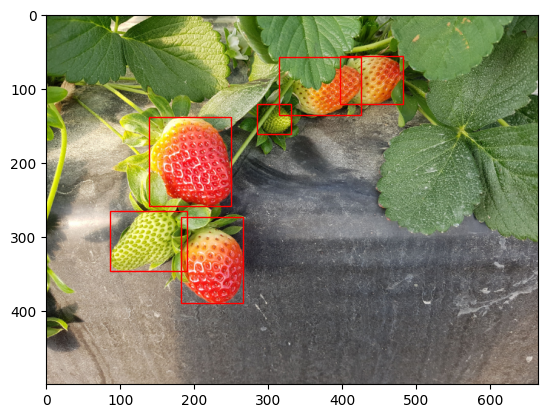

In [9]:
toolSet.drawIthTrainingData(89) # draw the 89th image with height=500,width=666

[1, 1, 1, 1, 1, 0]
397.0892857142857 55.22486772486773 481.99107142857144 120.37037037037037
314.5 56.87830687830687 425.16964285714283 134.5899470899471
285.0982142857143 120.03968253968254 331.3482142857143 160.38359788359787
181.36607142857142 273.80952380952385 265.9375 389.8809523809524
86.22321428571429 265.54232804232805 189.625 346.23015873015873
139.08035714285714 137.89682539682542 249.41964285714286 258.26719576719574


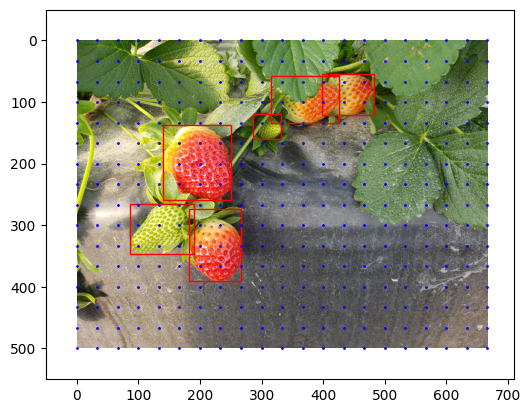

In [10]:
# generating groundTruth anchorbox centers
XpointsNum = 21 # this number depends on the output of our model. In our current implementation the model produces 21*16 outputs.
YpointsNum = 16 # this number depends on the output of our model. In our current implementation the model produces 21*16 outputs.
centerX = np.linspace(0, ImageWidth, XpointsNum, endpoint = True)
centerY = np.linspace(0, ImageHeight, YpointsNum, endpoint = True)

# draw the centers
# copying the XpointsNum centerX's YpointsNum times to produce XpointsNum*YpointsNum centerX for depicting purpose
DepictingCenterX = (centerX[:,np.newaxis] + np.zeros(YpointsNum)).flatten()
# copying the YpointsNum centerX's XpointsNum times to produce XpointsNum*YpointsNum centerX for depicting purpose (column-major)
DepictingCenterY = (centerY[:,np.newaxis] + np.zeros(XpointsNum)).flatten(order='F')

toolSet.CenterXYSetterForDraw(DepictingCenterX,DepictingCenterY)
toolSet.drawAnchorBoxCenters(89)


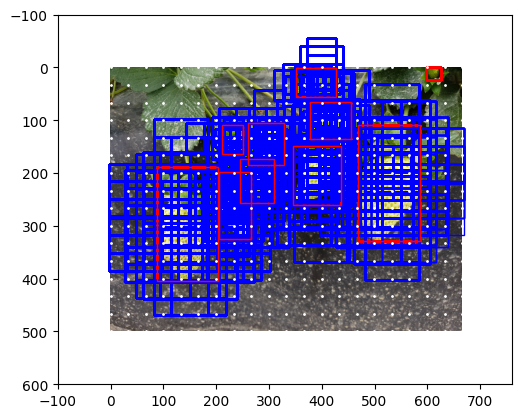

In [11]:
# generating anchor box shapes' x and y
# we create 3 different anchor boxes with 3 aspect ratios resulting in 9 anchor boxes in total
# areas of these anchor boxes must be equal to 32*32, 64*64, 128*128 in apsect ratios 1:1, 1:2, and 2:1

# our 9 anchor boxes are :
# 1. -> 1:2 -> area = 32*32 -> x=sqrt((32*32)/2), y=2*sqrt((32*32)/2)
# 2. -> 1:2 -> area = 64*64 -> x=sqrt((64*64)/2), y=2*sqrt((64*64)/2)
# 3. -> 1:2 -> area = 128*128 -> x=sqrt((128*128)/2), y=2*sqrt((128*128)/2)
# 4. -> 1:1 -> area = 32*32 -> x=32,y=32
# 5. -> 1:1 -> area = 64*64 -> x=64,y=64
# 6. -> 1:1 -> area = 128*128 -> x=128,y=128
# 7. -> 2:1 -> area = 32*32 -> x=2*sqrt((32*32)/2),y=sqrt((32*32)/2)
# 8. -> 2:1 -> area = 64*64 -> x=2*sqrt((64*64)/2),y=sqrt((64*64)/2)
# 9. -> 2:1 -> area = 128*128 -> x=2*sqrt((128*128)/2),y=sqrt((128*128)/2)

# anchorBox1 X  | anchorBox1 Y | ...
smallSize = 50 # was 32 initially
mediumSize = 80 # was 64 initially
bigSize = 145 # was 128 initially
A1X = np.sqrt((smallSize*smallSize)/2)
A1Y = 2*A1X
A2X = np.sqrt((mediumSize*mediumSize)/2)
A2Y = 2*A2X
A3X = np.sqrt((bigSize*bigSize)/2)
A3Y = 2*A3X
A4X = smallSize
A4Y = smallSize
A5X = mediumSize
A5Y = mediumSize
A6X = bigSize
A6Y = bigSize
A7X = 2*np.sqrt((smallSize*smallSize)/2)
A7Y = A7X/2
A8X = 2*np.sqrt((mediumSize*mediumSize)/2)
A8Y = A8X/2
A9X = 2*np.sqrt((bigSize*bigSize)/2)
A9Y = A9X/2

toolSet.AnchorSetter(A1X,A1Y,A2X,A2Y,A3X,A3Y,A4X,A4Y,A5X,A5Y,A6X,A6Y,A7X,A7Y,A8X,A8Y,A9X,A9Y)


TrainingObjectNessLabels,TrainingBboxRegLabels = toolSet.anchorBasedLabelGenerator(TrainingbboxLabels,trainData,True)
ValObjectNessLabels,ValBboxRegLabels = toolSet.anchorBasedLabelGenerator(ValbboxLabels,valData,False)
TestObjectNessLabels,TestBboxRegLabels = toolSet.anchorBasedLabelGenerator(TestingbboxLabels,testData,False)
        

In [12]:
TrainingObjectNessLabelsTensor = tf.convert_to_tensor(TrainingObjectNessLabels)
TrainingBboxRegLabelsTensor = tf.convert_to_tensor(TrainingBboxRegLabels)

ValObjectNessLabelsTensor = tf.convert_to_tensor(ValObjectNessLabels)
ValBboxRegLabelsTensor = tf.convert_to_tensor(ValBboxRegLabels)

TestObjectNessLabelsTensor = tf.convert_to_tensor(TestObjectNessLabels)
TestBboxRegLabelsTensor = tf.convert_to_tensor(TestBboxRegLabels)

In [13]:
BatchSize = 16
lab = np.array(TrainingObjectNessLabels)
averageTrueLabelPerImage = int(len(lab[lab==1])/2800) # we have 2800 training images

# # def rpn_loss(y_true, y_pred):

# #     print(objectness_scores.shape,objectness_labels.shape)
    
# # #     objectness_scores = y_pred[0::5]
# # #     indexes = [i for i in range(0,15120,5)]
# # #     deltasIndexes = []
# # #     for i in range(0,15120):
# # #         if i not in indexes:
# # #             deltasIndexes.append(i)
            
# # #     print(deltasIndexes)
# # #     bbox_deltas = tf.gather(y_pred,indices=deltasIndexes)
    

    



# #     # Mask for valid anchor positions (ignore padded anchors)
# # #     mask = tf.reduce_any(tf.math.not_equal(objectness_labels, -1), axis=-1)

# #     # Objectness Loss (Binary Cross-Entropy)
# #     objectness_loss = rpnClassification(objectness_labels, objectness_scores)
# # #     # BBox Regression Loss (Smooth L1 Loss)
# # #     bbox_labels = tf.boolean_mask(bbox_labels, mask)
# # #     bbox_deltas = tf.boolean_mask(bbox_deltas, mask)
# # #     bbox_loss = smooth_l1_loss(bbox_labels, bbox_deltas)
# # #     return objectness_loss + bbox_loss
# # #     print(objectness_loss.shape)
# #     return objectness_loss
    
    
def rpnClassification(y_true, y_pred):
    objectness_labels = y_true
    objectness_labels = tf.cast(objectness_labels,tf.float32)

    numberOfRois = averageTrueLabelPerImage*BatchSize*2 # we need to select averageTrueLabelPerImage*BatchSize 'true' and
    # 'false' labels, therefore we need to multiply it by 2.
    
    # half of Rois must be positive and half negative. If the number of positives if less than half of numberOfRios, we padd
    # our Roi set with the negative ones
    positiveRoiNum = numberOfRois/2
#     print(len(objectness_labels[objectness_labels==1]))
    if tf.cast(len(objectness_labels[objectness_labels==1]),tf.float32)<positiveRoiNum:
        positiveRoiNumAvailable = len(objectness_labels[objectness_labels==1])
    else:
        positiveRoiNumAvailable = int(positiveRoiNum)
    
    
    negativeRoiNumAvailable = numberOfRois-positiveRoiNumAvailable

    boolmaskPositive = tf.equal(objectness_labels,1)
    
    masklenpositive = len(tf.boolean_mask(y_pred,boolmaskPositive))
    positiveSelectedIndices = tf.random.uniform(shape=(positiveRoiNumAvailable,), minval=0,maxval=masklenpositive+1,dtype=tf.int32)
    
    
    positiveSelected_ypred=tf.gather(tf.boolean_mask(y_pred,boolmaskPositive),positiveSelectedIndices)
    positiveSelected_ytrue=tf.gather(tf.boolean_mask(objectness_labels,boolmaskPositive),positiveSelectedIndices)
#     positiveSelected_ypred = tf.boolean_mask(y_pred,boolmaskPositive)[:positiveRoiNumAvailable]
#     positiveSelected_ytrue = tf.boolean_mask(objectness_labels,boolmaskPositive)[:positiveRoiNumAvailable]
    
    boolmaskNegative = tf.equal(objectness_labels,0)
    
    masklennegative = len(tf.boolean_mask(y_pred,boolmaskNegative))
    negativeSelectedIndices = tf.random.uniform(shape=(negativeRoiNumAvailable,), minval=0,maxval=masklennegative+1,dtype=tf.int32)
    negativeSelected_ypred=tf.gather(tf.boolean_mask(y_pred,boolmaskNegative),negativeSelectedIndices)
    negativeSelected_ytrue= tf.gather(tf.boolean_mask(objectness_labels,boolmaskNegative),negativeSelectedIndices)
    
    
    
#     negativeSelected_ypred = tf.boolean_mask(y_pred,boolmaskNegative)[:negativeRoiNumAvailable]
#     negativeSelected_ytrue = tf.boolean_mask(objectness_labels,boolmaskNegative)[:negativeRoiNumAvailable]
    
    
    
    
    selectedYpred = tf.concat([positiveSelected_ypred,negativeSelected_ypred],axis=-1)
    selectedYtrue = tf.concat([positiveSelected_ytrue,negativeSelected_ytrue],axis=-1)

    BinaryLoss = tf.keras.losses.BinaryCrossentropy()
    loss = BinaryLoss(selectedYtrue,selectedYpred)

    return loss

def smooth_l1_loss(y_true, y_pred, sigma=1.0):
    
    
    bboxLabels = y_true
    # Smooth L1 Loss
    diff = tf.cast(bboxLabels,tf.float32) - y_pred
    abs_diff = K.backend.abs(diff)
    smooth_l1_loss = tf.where(tf.less(abs_diff, 1.0 / sigma**2), 0.5 * sigma**2 * tf.square(abs_diff), abs_diff - 0.5 / sigma**2)
    return smooth_l1_loss




In [14]:
input_t = K.Input(shape=(ImageHeight,ImageWidth,3))
# Load ResNet50 model
base_model = ResNet50(include_top=False, weights=None, input_tensor=input_t)

# Load weights from file
weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_file)

# Create a new model with the loaded weights
res_model = Model(inputs=base_model.input, outputs=base_model.output)

for layer in res_model.layers[:143]:
    layer.trainable = False

inputimg = tf.keras.Input(shape=(ImageHeight, ImageWidth, 3))
feature_maps = res_model(inputimg)

rpn_conv = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='rpn_conv')
rpn_output = rpn_conv(feature_maps)

rpn11_conv = tf.keras.layers.Conv2D(filters=9, kernel_size=(1, 1), activation='sigmoid', name='conv_objectness')
conv_objectness = rpn11_conv(rpn_output)

rpn12_conv = tf.keras.layers.Conv2D(filters=9*4, kernel_size=(1, 1) , name='rpn_bbox')
conv_bbox = rpn12_conv(rpn_output)

conv_objectnessFlattener = tf.keras.layers.Flatten(name='objectness_Score')
conv_objectnessFlat = conv_objectnessFlattener(conv_objectness)

conv_BboxFlattener = tf.keras.layers.Flatten(name='BboxScore')
conv_BboxFlat = conv_BboxFlattener(conv_bbox)


model = tf.keras.models.Model(inputs=inputimg, outputs=[conv_objectnessFlat,conv_BboxFlat])


model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 666, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 16, 21, 2048) 23587712    input_2[0][0]                    
__________________________________________________________________________________________________
rpn_conv (Conv2D)               (None, 16, 21, 256)  4718848     model[0][0]                      
__________________________________________________________________________________________________
conv_objectness (Conv2D)        (None, 16, 21, 9)    2313        rpn_conv[0][0]                   
____________________________________________________________________________________________

In [15]:
trainData = np.array(trainData)
valData = np.array(valData)
testData = np.array(testData)

In [20]:
###### check_point = K.callbacks.ModelCheckpoint(filepath="fruitHarvest.h5",monitor="val-acc",mode="max",save_best_only=True)

# model.compile(loss=[rpn_loss_fn, classification_loss_fn, bbox_regression_loss_fn],optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
#              metrics=['accuracy'])

# model.compile(loss={'conv_objectness': rpnClassification,'rpn_conv11': rpnBboxReg},optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
#              metrics=['accuracy'])


# tf.keras.losses.CategoricalCrossentropy()
model.compile(loss={"objectness_Score":rpnClassification,"BboxScore":smooth_l1_loss},loss_weights={"objectness_Score":1,"BboxScore":1},optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
             metrics={"objectness_Score":[K.metrics.Recall(),K.metrics.Precision(),toolSet.accuracy]})
# ,K.metrics.Recall(),K.metrics.Precision()

history = model.fit(x=trainData,y={"objectness_Score":TrainingObjectNessLabelsTensor,"BboxScore":TrainingBboxRegLabelsTensor},batch_size=16,epochs=100,verbose=1)
model.summary()

Epoch 1/100
175/175 [==============================] - 92s 505ms/step - loss: 1.6047 - objectness_Score_loss: 0.6194 - BboxScore_loss: 0.9853 - objectness_Score_recall_1: 0.6775 - objectness_Score_precision_1: 0.0634 - objectness_Score_accuracy: 0.4681
Epoch 2/100
175/175 [==============================] - 88s 505ms/step - loss: 1.5467 - objectness_Score_loss: 0.5766 - BboxScore_loss: 0.9700 - objectness_Score_recall_1: 0.7219 - objectness_Score_precision_1: 0.0745 - objectness_Score_accuracy: 0.5739
Epoch 3/100
175/175 [==============================] - 90s 516ms/step - loss: 1.5184 - objectness_Score_loss: 0.5500 - BboxScore_loss: 0.9684 - objectness_Score_recall_1: 0.7331 - objectness_Score_precision_1: 0.0810 - objectness_Score_accuracy: 0.6000
Epoch 4/100
175/175 [==============================] - 90s 512ms/step - loss: 1.4937 - objectness_Score_loss: 0.5265 - BboxScore_loss: 0.9672 - objectness_Score_recall_1: 0.7460 - objectness_Score_precision_1: 0.0871 - objectness_Score_accur

175/175 [==============================] - 89s 511ms/step - loss: 1.0080 - objectness_Score_loss: 0.0810 - BboxScore_loss: 0.9270 - objectness_Score_recall_1: 0.9854 - objectness_Score_precision_1: 0.4908 - objectness_Score_accuracy: 0.7789
Epoch 34/100
175/175 [==============================] - 89s 511ms/step - loss: 1.0042 - objectness_Score_loss: 0.0793 - BboxScore_loss: 0.9248 - objectness_Score_recall_1: 0.9856 - objectness_Score_precision_1: 0.4964 - objectness_Score_accuracy: 0.7814
Epoch 35/100
175/175 [==============================] - 91s 522ms/step - loss: 0.9987 - objectness_Score_loss: 0.0766 - BboxScore_loss: 0.9221 - objectness_Score_recall_1: 0.9864 - objectness_Score_precision_1: 0.5070 - objectness_Score_accuracy: 0.7881
Epoch 36/100
175/175 [==============================] - 92s 526ms/step - loss: 0.9918 - objectness_Score_loss: 0.0729 - BboxScore_loss: 0.9189 - objectness_Score_recall_1: 0.9866 - objectness_Score_precision_1: 0.5169 - objectness_Score_accuracy: 0.79

175/175 [==============================] - 92s 526ms/step - loss: 0.7778 - objectness_Score_loss: 0.0392 - BboxScore_loss: 0.7385 - objectness_Score_recall_1: 0.9929 - objectness_Score_precision_1: 0.6919 - objectness_Score_accuracy: 0.8826
Epoch 66/100
175/175 [==============================] - 92s 526ms/step - loss: 0.7705 - objectness_Score_loss: 0.0383 - BboxScore_loss: 0.7322 - objectness_Score_recall_1: 0.9928 - objectness_Score_precision_1: 0.6961 - objectness_Score_accuracy: 0.8839
Epoch 67/100
175/175 [==============================] - 92s 526ms/step - loss: 0.7644 - objectness_Score_loss: 0.0382 - BboxScore_loss: 0.7262 - objectness_Score_recall_1: 0.9929 - objectness_Score_precision_1: 0.7003 - objectness_Score_accuracy: 0.8852
Epoch 68/100
175/175 [==============================] - 92s 526ms/step - loss: 0.7564 - objectness_Score_loss: 0.0370 - BboxScore_loss: 0.7194 - objectness_Score_recall_1: 0.9932 - objectness_Score_precision_1: 0.7055 - objectness_Score_accuracy: 0.88

175/175 [==============================] - 92s 528ms/step - loss: 0.5635 - objectness_Score_loss: 0.0233 - BboxScore_loss: 0.5402 - objectness_Score_recall_1: 0.9955 - objectness_Score_precision_1: 0.8010 - objectness_Score_accuracy: 0.9276
Epoch 98/100
175/175 [==============================] - 93s 529ms/step - loss: 0.5586 - objectness_Score_loss: 0.0225 - BboxScore_loss: 0.5361 - objectness_Score_recall_1: 0.9959 - objectness_Score_precision_1: 0.8066 - objectness_Score_accuracy: 0.9292
Epoch 99/100
175/175 [==============================] - 92s 528ms/step - loss: 0.5535 - objectness_Score_loss: 0.0220 - BboxScore_loss: 0.5315 - objectness_Score_recall_1: 0.9958 - objectness_Score_precision_1: 0.8085 - objectness_Score_accuracy: 0.9296
Epoch 100/100
175/175 [==============================] - 92s 527ms/step - loss: 0.5503 - objectness_Score_loss: 0.0220 - BboxScore_loss: 0.5283 - objectness_Score_recall_1: 0.9959 - objectness_Score_precision_1: 0.8099 - objectness_Score_accuracy: 0.9

In [21]:
TrainingPredictions = model.predict(trainData)
print(TrainingPredictions)

ValPredictions = model.predict(valData)
print(ValPredictions)

TestingPredictions = model.predict(testData)
print(TestingPredictions)

[array([[8.98036826e-03, 1.52369048e-02, 1.00738062e-02, ...,
        8.86728521e-05, 3.15366546e-04, 8.98830185e-05],
       [3.94147646e-05, 1.48906920e-05, 1.77202775e-04, ...,
        1.11203844e-04, 7.08779990e-05, 1.04094950e-04],
       [2.23930010e-06, 1.60196578e-06, 1.01529995e-05, ...,
        8.70695076e-05, 2.11687860e-04, 4.97793022e-04],
       ...,
       [7.65836674e-08, 1.21336413e-07, 8.41871554e-07, ...,
        3.89908528e-04, 1.94827080e-04, 2.87513656e-04],
       [7.68390350e-07, 2.39323128e-07, 9.19364822e-07, ...,
        5.98136976e-04, 8.36645835e-04, 6.36170199e-03],
       [2.10999092e-03, 9.96245071e-04, 1.98916998e-03, ...,
        1.23369737e-05, 1.07871692e-05, 1.05228573e-05]], dtype=float32), array([[ 3.63642164e-03, -1.43545531e-02,  1.33480038e-02, ...,
         3.14763933e-03,  2.08140500e-02, -2.06444133e-02],
       [ 8.93720426e-04, -1.91750622e-03,  2.60153553e-03, ...,
         1.52821764e-02, -5.22434711e-05,  6.47836924e-03],
       [-5.798

In [22]:
toolSet.presRecall(TrainingPredictions[0],TrainingObjectNessLabels)
toolSet.presRecall(TrainingPredictions[1],TrainingBboxRegLabels) # precision and recall cannot be used for regression, this is being used only for debugging purposes.
print(tf.reduce_sum(smooth_l1_loss(TrainingPredictions[1],TrainingBboxRegLabels))/(2800*3024))
print(tf.reduce_sum(tf.keras.metrics.mean_squared_error(TrainingPredictions[1],TrainingBboxRegLabels))/(2800))
print()

toolSet.presRecall(ValPredictions[0],ValObjectNessLabels)
toolSet.presRecall(ValPredictions[1],ValBboxRegLabels) # precision and recall cannot be used for regression, this is being used only for debugging purposes.
print(tf.reduce_sum(smooth_l1_loss(ValPredictions[1],ValBboxRegLabels))/(100*3024))
print(tf.reduce_sum(tf.keras.metrics.mean_squared_error(ValPredictions[1],ValBboxRegLabels))/(100))
print()

toolSet.presRecall(TestingPredictions[0],TestObjectNessLabels)
toolSet.presRecall(TestingPredictions[1],TestBboxRegLabels) # precision and recall cannot be used for regression, this is being used only for debugging purposes.
print(tf.reduce_sum(smooth_l1_loss(TestingPredictions[1],TestBboxRegLabels))/(200*3024))
print(tf.reduce_sum(tf.keras.metrics.mean_squared_error(TestingPredictions[1],TestBboxRegLabels))/(200))
print()

precision: 0.8060415176175997
recall: 0.9974098281287824
precision: 0.4918840430506046
recall: 0.8049581352413344
tf.Tensor(2.0582223, shape=(), dtype=float32)
tf.Tensor(17.877035, shape=(), dtype=float32)

precision: 0.14102969046114971
recall: 0.08811920268403395
precision: 0.0922217384994921
recall: 0.06333150630325378
tf.Tensor(3.789148, shape=(), dtype=float32)
tf.Tensor(46.097733, shape=(), dtype=float32)

precision: 0.1364380996957641
recall: 0.09080996884735203
precision: 0.08863252673044457
recall: 0.0663454703419951
tf.Tensor(3.6066666, shape=(), dtype=float32)
tf.Tensor(43.529774, shape=(), dtype=float32)



In [23]:
# checking the number of 'true' predictions and 'true' labels in the Training set
print(len(TrainingPredictions[0][TrainingPredictions[0]>0.5]))
lab = np.array(TrainingObjectNessLabels)
len(lab[lab==1])

357823


289169